# Manipulating Layers of ARIA standard GUNW products

**Author**: Brett A. Buzzanga, David Bekaert - Jet Propulsion Laboratory

This notebook documents the methodology used for extracting data and metadata layers of ARIA Geocoded UNWrapped interferogram (**GUNW**) products. It provides command-line and python examples that include visualizations and an application. 

Specifically, we detail the methodology used in extracting:
- product bounding box, amplitude, and coherence,
- imaging geometry, 
- unwrapped phase. 

We then show examples which use the tools to extract based on:
- the full union of the acquisition frames (no bounding box),
- a bounding box of SNWE coordinates in decimal degrees,
- a bounding box in the form of a vector shapefile.

Finally, we demonstrate how to generate a deformation map in a georeferenced coordinate system. 

    
<div class="alert alert-danger">
Both the initial setup (Section A) and download of the data (Section B) should be run at the start of the notebook. However, the numbered sections do not need to be run in numerical order. </b>
</div>

<div class="alert alert-danger">
<b>Potential Errors:</b> 
If the driver is not captured as "netCDF/Network Common Data Format" verify GDAL version is at least 2.5.

The folder containing the ARIA python tools must be in your path. If it's not you can add it like so:
    
`os.environ["PATH"] += os.pathsep + "path_to_tools"`
</div>


## Prep A. Initial setup of the notebook

We start by importing the necessary python libraries, setting the paths we will use to access and store data, and defining a function to plot a layer.

**This step only needs to be ran at the very beginning, but it must be run every time the notebook is restarted.**


In [1]:
import os
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
## add the aria tools to your path
path_tools = os.path.join(os.path.expanduser('~'), 'Software_InSAR', 'ARIA-tools_git', 'tools', 'python')
os.sys.path.append(path_tools)
os.environ["PATH"] += os.pathsep + path_tools

try:
    import shapefile_util as shputil
except:
    raise Exception('ARIA-tools missing from path')

# Enable GDAL/OGR exceptions
gdal.UseExceptions()

## Defining the home and data directories at the processing location
home_dir = os.getcwd()
tutorial_home_dir = os.path.abspath(os.path.join(home_dir, ""))
data_dir = os.path.join(tutorial_home_dir, 'data')
supp_dir = os.path.join(tutorial_home_dir, 'support_docs')
print("home directory: ", tutorial_home_dir)

# data file
fileNames = [os.path.join(data_dir, i) for i in ['S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc', 'S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc']]


# generate all the folders in case they do not exist yet
if not os.path.exists(tutorial_home_dir):
    os.makedirs(tutorial_home_dir)
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
os.chdir(tutorial_home_dir)

home directory:  /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct


In [121]:
def plot_layers(path_layers, **kwargs):
    """ path_layers can be a string or a list of up to 4 layers"""
    if not isinstance(path_layers, list):
        path_layers = [path_layers]
    n_layers = len(path_layers)
    if len(path_layers) > n_layers:
        raise Exception('Can only pass <= 4 layers')
    else:
        n_cols = 2 if n_layers == 4 else n_layers 
        n_rows = 2 if n_layers == 4 else 1
        
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16,9))
    if not isinstance(axes, np.ndarray):
        axes  = np.array(axes)
    axe       = axes.ravel()
    cmap = plt.cm.Greys_r
    cmap.set_under('black')
    
    for i, ax in enumerate(axe):
        lay_type = os.path.dirname(path_layers[i])
        ds  = gdal.Open(path_layers[i], gdal.GA_ReadOnly)
        arr = ds.ReadAsArray()
        if lay_type.endswith('amplitude'):
            ax.imshow(arr, cmap=cmap, vmax=2000, **kwargs)# you may have to adjust vmax for diff scenes
        elif lay_type.endswith('coherence'):
            ax.imshow(arr, cmap=cmap, **kwargs)
        elif lay_type.endswith('incidenceAngle'):
            ax.imshow(arr, cmap=cmap, vmin=np.quantile(arr, 0.53), **kwargs)
        elif lay_type.endswith('bPerpendicular'):
            # ax.imshow(arr, cmap=cmap, vmin=arr.min(), vmax=arr.max(), **kwargs)
            raise Exception('use productPlot.py to view baseline information')
            
            
        ax.grid(False)
        ax.set_title(os.path.basename(lay_type))

## Prep B: Download the data
The GUNW products are packages as netCDF4 files and include both data and meta-data layers such as interferogram amplitude, filtered unwrapped phase, filtered coherence, connected components, perpendicular and parallel baselines, incidence, azimuth and look angles. A detailed overview of the ARIA GUNW product with respect to processing, formatting, sampling, and data layers can be found on the ARIA website.

Products can be downloaded from the ARIA-products page and ASF DAAC vertex page under beta products. If you know the product filename you can construct the download link by appending the filename to the following URL: https://grfn.asf.alaska.edu/door/download/

For our dataset we are focusing on two adjacent frames from ascending track 124 of Sentinel-1 with an interferogram generated between 20180423 and 20180505. The two frames span 19.661N to 17.420N and 21.158N to 19.086N, respectively, thus it is clear they are adjacent in that they overlap bewteen 19.661N and 19.086N. Together, the two frames cover the entirety of the Big Island of Hawai'i. The interferogram dates capture a coseismic earthquake that occured on May 4, 2018 in the Southeastern corner of the Island (Fig. 1).

<img src="support_docs/Hawaii_shakemap.png" alt="region" width="500">


Given that we already know the product filenames we can download them by constructing the download URLs:
    - https://grfn.asf.alaska.edu/door/download/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc
- https://grfn.asf.alaska.edu/door/download/S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc

## 1 Overview of extractProduct.py

### 1.1  Basics

First, we show how to call extractProduct.py and view the help. In the help is a description for each possible input argument. The effects of these arguments will be demonstrated in more detail in the sections that follow. 
A digital elevation model (DEM) is required for processing. The user can specify the location to a custom one, or pass `-d Download` to download on the fly from NASA SRTM mission.

Note that multiple ARIA files (`-f`) and layers (`-l`) can be specified by separating the filenames by a **space** or using a wildcard (`-f 'S1*'`), and the layer names with a **comma** (`-l 'azimuth,coherence'`).

In [129]:
cmd = '-h'
!extractProduct.py {cmd}

usage: extractProduct.py [-h] -f IMGFILE [-w WORKDIR] -l LAYERS [-d DEMFILE]
                         [-p PROJECTION] [-b BBOX] [-m MASK]
                         [-of OUTPUTFORMAT] [-croptounion] [-verbose]

Program to extract data and meta-data layers from ARIA standard GUNW products.
Program will handle cropping/stiching when needed.

optional arguments:
  -h, --help            show this help message and exit
  -f IMGFILE, --file IMGFILE
                        ARIA file
  -w WORKDIR, --workdir WORKDIR
                        Specify directory to deposit all outputs. Default is
                        local directory where script is launched.
  -l LAYERS, --layers LAYERS
                        Specify layers to extract as a comma deliminated list
                        bounded by single quotes. Allowed keys are:
                        "unwrappedPhase", "coherence", "amplitude",
                        "bPerpendicular", "bParallel", "incidenceAngle",
                        "lookA

### 1.2  Spatio-temporal Configuration
Before more advanced operations are performed, the program determines the alignment of the requested frames in space and time. 
The user can input a list of interferograms acquired over one or more satellite paths, as long as frames overlap within each path (see [Prep B](#Dowload-the-Data)).
The default is to separate the data in time, and stitch the spatial **intersection** of the given frames in the along-track direction.
If the user wants to use the full union of the frames, or if the satellite paths do not intersect, **pass the `--croptounion` flag**.
Note that along the equator track number gets incremented in the product name but the data itself is still continuous? 

The following plot shows the 2 valid spatial configurations for pairs of interferograms:
<img src="support_docs/spatial_configuration.png" alt="spatial_configuration" width="800">
 
<div class="alert alert-warning">
    <b>Warning:</b> The user is responsible for ensuring for there is an overlap between frames in the along-track direction. 
</div>
$%We can then plot the shapefile of our bounding box as follows:$

### 1.3 Cropping 
The program then crops based on the user-defined bounding box. 
If no bounding box is given, the program defaults to use the intersection of the frame.
If you wish to use the full union of the frames without a bounding box, pass the `--croptounion` flag.  Alternatively, the user can specify a rectangular bounding box of SNWE decimal degree coordinates as `-b 'S N W E'` or a vector shapefile `-b path_to_file.shp` (note the lack of quotes surrounding the path argument). 

Examples of the different cropping scenarios are shown in [Section 3](#3).

All layers except the unwrapped phase and connected components are stitched without mathematical processing using GDAL. The offsets betwen connected components and unwrapped phase in adjacent frames are handled using the spatial overlap (for full details see [Section 2.3](#Extracting-Unwrapped-Phase)).



<div class="alert alert-danger">
    <b>DAVID:</b> Is it necessary to show more figures here? - I think it's self explanatory with the plots above, and the different cases are below in examples
    </div>

### 1.4 Full Resolution Meta-Data
Unlike many other interferometric? processing softwares, this program extracts the full resolution ImagingGeometry meta-data, including perpendicular and parallel baselines, and azimuth, incidence and look angles.
These data are packaged in the GUNW products as 3D data cubes referenced to several height levels.
extractProduct.py will intersect the given DEM, interpolating between the reference levels to the height of the DEM for each point in 2D space.
$%3D grid main data compression. Its smooth on a 3D and can be done on a course resolution. topography enforces the high resolution$


### 1.5  Output Format
The program will write data as virtual (.vrt) files unless the user requests a different format, such as ENVI or ISCE.
These files contain processing instructions in an XML structure, rather then the processed data itself. 
This paradigm improves both processing efficiency and use of disk space.
However, certain layers, such as the unwrapped phase and imaging geometry, will need to be physically written to disk for mathematical manipulation.

## 2 Methods

### 2.1 Two-Dimensional Stitching
These layers do not require manipulation of the data to stich, they are average together.
E.g. of layers such as amplitude, coherence, 3D cubes
Not for unwrapped phase

### 2.2 Extracting ImagingGeometry layers 
Stiching of (e.g. line-of-sight, baseline)
Provide a schematic to explain the process (screenshot)
We first stich the 3D cube first from multiple products, then interpolate to the new grid in Spatially then crop to the bbox, then a linear in the vertical to intersect with the DEM
DEM is downloaded on the fly if requested.

### 2.3 Extracting Unwrapped Phase
Explain the minization procedure in overlap regions between product.
Explain what happens to the connected component file and how they are corrected
Could show the bounding box and then color the union, say we will compute the residual between the products in the intersect region

total of connected components of used; offset is applied and only overlap section of master is used.

## 3 Examples

In [127]:
### 3.1 Extract layer without a bounding box

Here we demonstrate how to extract a layer without using a bounding box over the scenes over Hawai'i described in [Prep B](#Dowload-the-Data)).
The program will default to the intersection of the two scenes. 
Since we are only using data acquired over one satellite path, this is equivalent to the union of the two scenes.

We will force the program to download a DEM on the fly with the flag `-d Download`'.
We will extract and view the amplitude and coherence. 
The data will be saved in **supp_dir** we set above, with separate subdirectories for each layer name. Within the subdirectory, the data and metadata are saved with the interferogram pair dates as the basename.

Running extractProduct.py -f '/Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc' -l 'amplitude,coherence' -d Download -w /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/support_docs
########################################
class 'Aria_standardproduct': sort input file(s) by starting time
if user bbox was specified, file(s) not meeting imposed spatial criteria are rejected.

Outputs = arrays ['standardproduct_info.products'] containing grouped “radarmetadata info” and “data layer keys+paths” dictionaries for each standard product + path to bbox file ['standardproduct_info.bbox_file'] (if bbox specified).

All 2 input files successfully passed!
Group spatiotemporally continuous IFGs.

All 1 input files succes

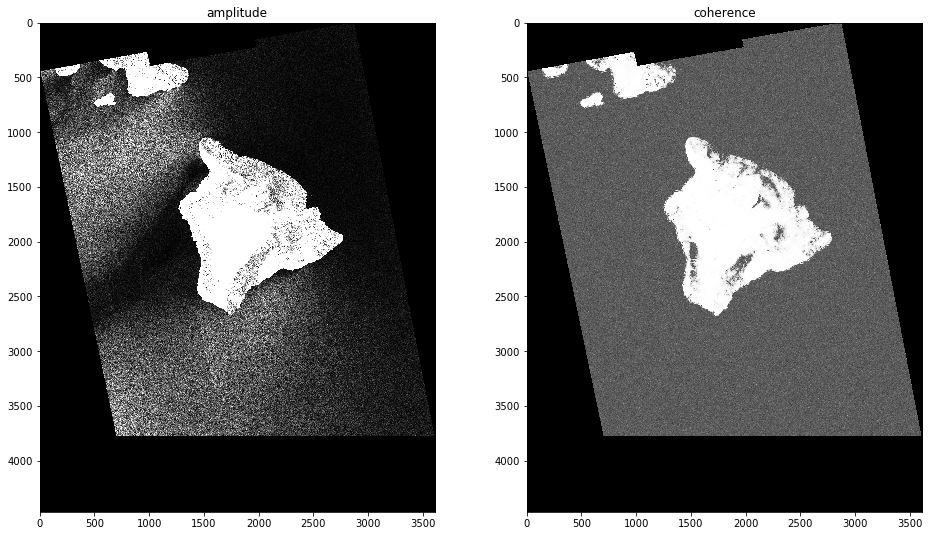

In [59]:
layers = ['amplitude', 'coherence']
cmd    = "-f '{}' -l '{}' -d Download -w {}".format(' '.join(fileNames), ','.join(layers), supp_dir,)

print ('Running extractProduct.py {}'.format(cmd))
!extractProduct.py {cmd}

# set paths and view the plots
layer_dest = [os.path.join(supp_dir, layer, '20190304_20190226') for layer in layers]
plot_layers(layer_dest)

The amplitude plot on the left shows the magnitude of the stitched interferometric pair. Weaker (darker) values indicate weaker backscatter of the radar signal.

The coherence plot on the right is a measure of the similarity between observations in the two SAR images that compose the interferometric pair and ranges from 0 (no coherence) to 1 (identically coherent). Capillary waves superimposed on larger scale fluctuations cause water to have little coherence from one acquisition to the next, as easily viewed here. 

### 3.2 Extract layer with SNWE coordinates
To focus analysis, the user can specify a rectangular bounding box of SNWE coordinates as a space delimited list surround by quotes.
Here we focus on the Big Island of Hawai'i using coordinates `SNWE = '18.8 20.3 -156.1 -154.5'`. As in the previous example, we will download the DEM on the fly by passing `-d Download` and view both the amplitude and coherence. Again, the data will be saved in **supp_dir** we set above, with separate subdirectories for each layer name. Within the subdirectory, the data and metadata are saved with the interferogram pair dates as the basename. Any existing layers will be overwritten.

Note that if the user ran the previous cell, he/she does not need to specify a DEM; the program will find it automatically.

Running extractProduct.py -f '/Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc' -l 'incidenceAngle' -d Download -w /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/support_docs --bbox '18.8 20.3 -156.1 -154.8'
########################################
class 'Aria_standardproduct': sort input file(s) by starting time
if user bbox was specified, file(s) not meeting imposed spatial criteria are rejected.

Outputs = arrays ['standardproduct_info.products'] containing grouped “radarmetadata info” and “data layer keys+paths” dictionaries for each standard product + path to bbox file ['standardproduct_info.bbox_file'] (if bbox specified).

Shapefile /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractPr

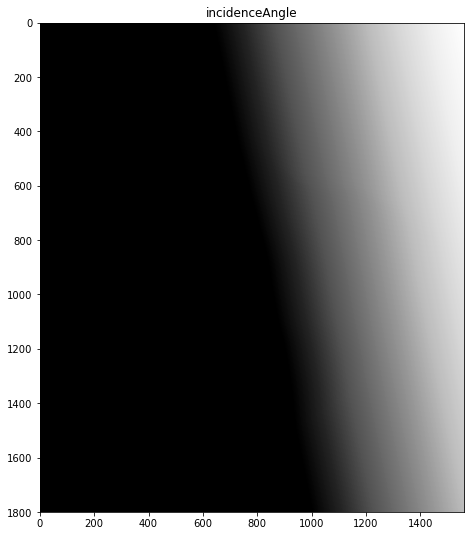

In [128]:
SNWE = '18.8 20.3 -156.1 -154.8'
cmd    = "-f '{}' -l '{}' -d Download -w {} --bbox '{}'".format(' '.join(fileNames), ','.join(layers), supp_dir, SNWE)

print ('Running extractProduct.py {}'.format(cmd))
!extractProduct.py {cmd}

# set paths and view the plots
layer_dest = [os.path.join(supp_dir, layer, '20190304_20190226') for layer in layers]
plot_layers(layer_dest)


### 3.3  Extract layer using a shapefile
Another option for focusing on a region is to pass a user defined data. **The data must be a vector dataset of polygons, readable by GDAL***. 
These include ESRI shapefiles and geoJSON structures.
If it is not referenced to WGS84 you can pass a the projection with `-p your_proj` (untested).

Here we crop to the eastern corner of the Big Island of Hawai'i, which contains the epicenter of the earthquake. 
We will extract and view the incidence angle.
As in the previous example, we will download the DEM on the fly by passing `-d Download`
Once more, the data will be saved in **supp_dir** we set above, with separate subdirectories for each layer name. Within the subdirectory, the data and metadata are saved with the interferogram pair dates as the basename. Any existing layers will be overwritten.

Running extractProduct.py -f '/Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-042953-19661N_17420N-PP-720e-v2_0_1.nc /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/data/S1-GUNW-A-R-124-tops-20190304_20190226-043020-21158N_19086N-PP-5415-v2_0_1.nc' -l 'incidenceAngle' -w /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/support_docs -d Download -b /Users/bb/Software_InSAR/ARIA-tools-docs_git/JupyterDocs/extractProduct/support_docs/Big_Island/Hawaii_Poly_wgs84.shp
########################################
class 'Aria_standardproduct': sort input file(s) by starting time
if user bbox was specified, file(s) not meeting imposed spatial criteria are rejected.

Outputs = arrays ['standardproduct_info.products'] containing grouped “radarmetadata info” and “data layer keys+paths” dictionaries for each standard product + path to bbox file ['standardproduct_info.bbox_file'] (if bbox s

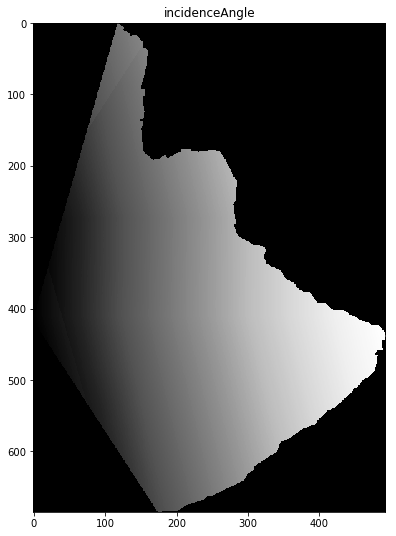

In [122]:
layers = ['incidenceAngle']
shp    = os.path.join(supp_dir, 'Big_Island', 'Hawaii_Poly_wgs84.shp')
cmd    = "-f '{}' -l '{}' -w {} -d Download -b {}".format(' '.join(fileNames), ','.join(layers), supp_dir, shp)
print ('Running extractProduct.py {}'.format(cmd))
!extractProduct.py {cmd}
layer_dest = [os.path.join(supp_dir, layer, '20190304_20190226') for layer in layers]
plot_layers(layer_dest)

The incidence angles generally decrease from East to west, from a high of 43.55 to 41.86.

## Applications

### 4.1 Generation of Georeferenced Displacement Map

In [ ]:
# Extract incidence angle, heading together using the lsit option
# Extract the wavelength from the product (this is not supported by default)
# Generate the ENU conversion and use function to generate the products

# BELOW IS OLD/EXTRA CODE

### 1.1 Merging of the two scenes
Here we demonstrate how to extract the **amplitude** data of the scenes.
Inputting both scenes to extracProduct.py program will automatically merge them.
We also show how to automatically download the required digital elevation model (DEM).

In [ ]:
layers = ['amplitude']
ifgs   = '{} {}'.format(path_ifg1, path_ifg2)
# ifgs   = '{}'.format(path_ifg1)
# cmd    = "--file '{}' --layers '{}' --workdir {} --demfile=Download".format(ifgs, ','.join(layers), res_dir)
cmd    = "--file '{}' --layers '{}' --workdir {}".format(ifgs, ','.join(layers), res_dir)
print ('Running extractProduct.py {}'.format(cmd))
print ('Finished extracting {}'.format(layers))

### 1.1. View Extracted Amplitude
The extraction tool creates a raster with basename of the interferogram dates and no extension in res_dir/amplitude.
It also creates a .vrt file (for use with GDAL, see the GDAL Notebook[LINK]), and an .xml file that is neede for ISCE[LINK] tools such as mdx.py.


Here we demonstrate a quick look at the resulting amplitude data using GDAL and matplotlib.

In [ ]:
path_ifg = os.path.join(res_dir, 'amplitude', '20190304_20190226')


### 1.2. View Product Bounding Box
Additionally, 2 geojson files (.shp) are created in res_dir/productBoundingBox.
The one with basename of the interferogram dates is bounding box of each scene? and the productBoundingBox_total.shp is total product? (will check later)

In [126]:
# product_bbox  = os.path.join(res_dir, 'productBoundingBox', '20190304_20190226.shp')
# product_total = os.path.join(res_dir, 'productBoundingBox', 'productBoundingBox_total.shp')

# plot_shapefile(product_bbox)
# plot_shapefile(product_total)

## 2. Crop the merged dataset

### 2.1 We'll now crop out most of the water around the Big Island using a lat/lon bounding box

In [ ]:
SNWE = '18.8 20.3 -156.1 -154.5'
layers = ['amplitude']
ifgs   = '{} {}'.format(path_ifg1, path_ifg2)
cmd    = "-f '{}' -l '{}' -w {} --bbox '{}' ".format(ifgs, ','.join(layers), res_dir, SNWE)
print ('Running extractProduct.py {}'.format(cmd))
# !extractProduct.py {cmd}
print ('Finished cropping {}'.format(layers))

### 2.1 View Bounding Box 2

In [26]:
bbox_1 = os.path.join(supp_dir, 'productBoundingBox', '20161003_20160822.shp')
bbox_2 = os.path.join(supp_dir, 'productBoundingBox', '20170206_20170107.shp')
bbox_3 = os.path.join(supp_dir, 'productBoundingBox', '20190304_20190226.shp')
bbox_4 = os.path.join(supp_dir, 'productBoundingBox', '20160729_20160611.shp')
bbox_5 = os.path.join(supp_dir, 'productBoundingBox', '20160810_20160506.shp')
bbox_total = os.path.join(supp_dir, 'productBoundingBox', 'productBoundingBox_total.shp')
# bbox_list = [bbox_1, bbox_2, bbox_3, bbox_total]
bbox_list = [bbox_4, bbox_5, bbox_total]
for bbox in bbox_list:
#     shputil.plot_shapefile(bbox)
    pass

In [27]:
bbox_1 = os.path.join(supp_dir, 'productBoundingBox', '20161003_20160822.shp')
bbox_2 = os.path.join(supp_dir, 'productBoundingBox', '20170206_20170107.shp')
bbox_4 = os.path.join(supp_dir, 'productBoundingBox', '20160729_20160611.shp')
bbox_5 = os.path.join(supp_dir, 'productBoundingBox', '20160810_20160506.shp')
bbox_total = os.path.join(supp_dir, 'productBoundingBox', 'productBoundingBox_total.shp')
# bbox_list = [bbox_1, bbox_2, bbox_3, bbox_total]
bbox_list = [bbox_4, bbox_5, bbox_total]
for bbox in bbox_list:
#     shputil.plot_shapefile(bbox)
    pass

### 2.2 View cropped Amplitude
The cropping routine will have produced a shapefile with our bounding box (user_bbox.shp) in res_dir, and overwritten the files in the res_dir/amplitude.

Let's take a quick look at the cropped data.

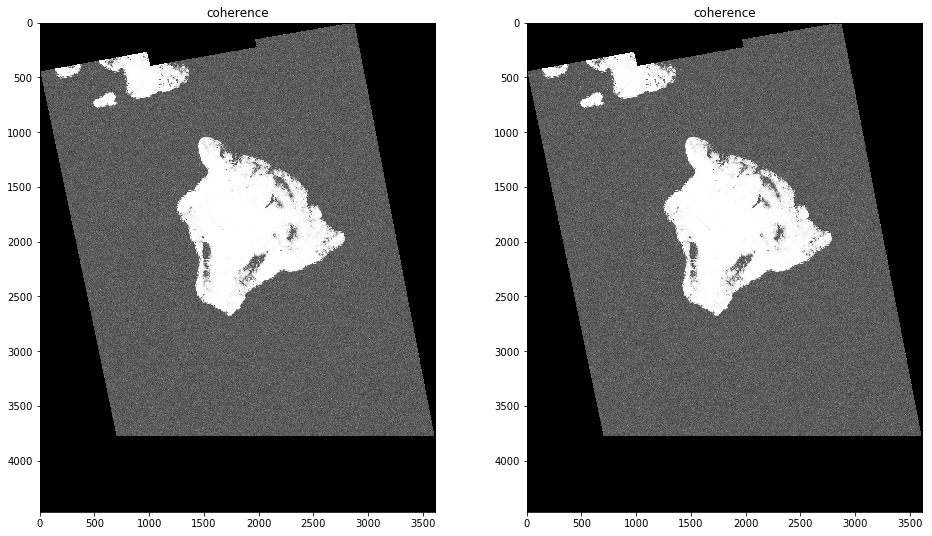

In [123]:
path_ifg1 = os.path.join(supp_dir, 'coherence', '20161003_20160822.vrt')
path_ifg2 = os.path.join(supp_dir, 'coherence', '20170206_20170107.vrt')
path_ifg3 = os.path.join(supp_dir, 'coherence', '20190304_20190226.vrt')
path_ifg4 = os.path.join(supp_dir, 'coherence', '20190304_20190226.vrt')
# plot_layers([path_ifg1, path_ifg2, path_ifg3, path_ifg4])
plot_layers([path_ifg3, path_ifg4])

# path_ifg5 = os.path.join(supp_dir, 'bPerpendicular', '20160729_20160611.vrt')
# path_ifg6 = os.path.join(supp_dir, 'bPerpendicular', '20160810_20160506.vrt')
#plot_layers([path_ifg5, path_ifg6])


In [125]:
# https://osmdata.openstreetmap.de/data/coastlines.html
# ifgs   = '{} {}'.format(path_ifg1, path_ifg2)
# cmd    = "-f '{}' -l '{}' -w {} --bbox '{}'".format(ifgs, ','.join(layers), res_dir, shp)
# print ('Running extractProduct.py {}'.format(cmd))
# !extractProduct.py {cmd}
# print ('Finished cropping with shapefile {}'.format(layers))